# AlexNet with tf-slim

## Highly inspired (and copy-pasted) from the [slim-walkthrough notebook](https://github.com/tensorflow/models/blob/master/slim/slim_walkthrough.ipynb)

Navigate to the models directory to gain access to the dataset helper methods to handle the **flowers** dataset

In [1]:
ll

total 876
-rw-rw-r-- 1 niklas   2097 Mai 27 19:31 alexnet.py
-rw-rw-r-- 1 niklas 878395 Mai 30 15:14 alexnet-tf-slim.ipynb
drwxrwxr-x 2 niklas   4096 Mai 30 12:58 logs/
-rw-rw-r-- 1 niklas   6125 Mai 30 15:04 README.md


In [2]:
cd ~/ML-KA/tensorflow/models/slim/

/home/niklas/ML-KA/tensorflow/models/slim


In [3]:
ll

total 136
drwxr-xr-x 3 niklas  4096 Mai 30 13:01 ~/
-rw-rw-r-- 1 niklas  7172 Mai 24 16:29 BUILD
drwxrwxr-x 4 niklas  4096 Mai 30 11:44 datasets/
drwxrwxr-x 2 niklas  4096 Mai 24 16:29 deployment/
-rw-rw-r-- 1 niklas  2306 Feb 19 23:03 download_and_convert_data.py
-rw-rw-r-- 1 niklas  6666 Mai 24 16:29 eval_image_classifier.py
-rw-rw-r-- 1 niklas     1 Mär  1 00:35 __init__.py
drwxrwxr-x 3 niklas  4096 Mai 27 16:35 nets/
drwxrwxr-x 2 niklas  4096 Mai 30 13:18 preprocessing/
-rw-rw-r-- 1 niklas 17487 Mai 24 16:29 README.md
drwxrwxr-x 2 niklas  4096 Mai 24 16:29 scripts/
-rw-rw-r-- 1 niklas 45649 Mai 24 16:29 slim_walkthrough.ipynb
-rwxrwxr-x 1 niklas 20042 Mai 24 16:29 train_image_classifier.py*
-rw-rw-r-- 1 niklas     0 Mai 24 16:29 WORKSPACE


In [4]:
import tensorflow as tf
from datasets import dataset_utils, flowers
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

/home/niklas/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


In [5]:
flowers_data_dir = '/media/niklas/lin-win-hdd/nn_datasets/image/flowers2'

In [6]:
# url = "http://download.tensorflow.org/data/flowers.tar.gz"
# dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir)

## Display the data

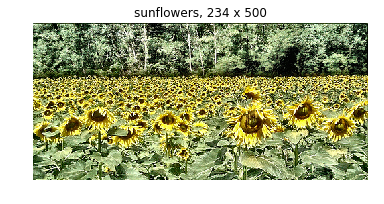

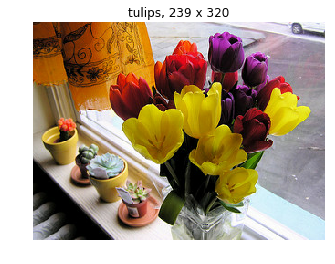

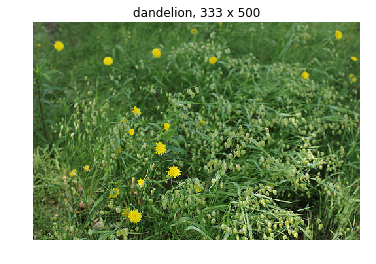

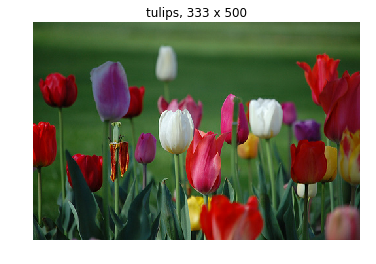

In [7]:
slim = tf.contrib.slim

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in xrange(4): 
                # creates a generator, "yield"
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]

                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

Images have different sizes and are very heterogeneous

In [8]:
dataset.num_samples

3320

## A function to load batches from the dataset

In [9]:
from preprocessing import inception_preprocessing
import tensorflow as tf

slim = tf.contrib.slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels


In [ ]:
from datasets import flowers
from tensorflow.contrib.slim.nets import alexnet
import numpy as np

# This might take a few minutes.
train_dir = '/home/niklas/ML-KA/tensorflow/team-tensorflow/sprint3_tf_models/src/alexnet/logs'
print('Will save model to %s' % train_dir)
batch_size = 32

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = flowers.get_split('train', flowers_data_dir)
    # adjust height and width to alexnet dimensions
    # images: preprocessed images
    # images_raw: raw images
    images, images_raw, labels = load_batch(dataset, batch_size=batch_size, height=224 ,width=224)
  
    # Create the model:
    # net returns the logit values, end_points returns the nodes / operations 
    # (ordered dict to retain the ordering, very clever!) 
    net, end_points = alexnet.alexnet_v2(images, num_classes=dataset.num_classes, is_training=True)
 
    # make summaries of every operation in the node
    for layer_name, layer_op in end_points.items():
        tf.summary.histogram(layer_name, layer_op)
    
    # Specify the loss function (outside the model!)
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(net, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Track accuracy and recall
    predictions = tf.argmax(net, 1)
    
    # Define the metrics:
    # Recall@5 would make no sense, because we have only 5 classes here
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/Recall@2': slim.metrics.streaming_recall_at_k(net, labels, 2),
    })
    for name, tensor in names_to_updates.items():
        tf.summary.scalar(name, tensor)

    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        number_of_steps=int(100*np.floor(dataset.num_samples / batch_size)), # For speed, we just do 1 epoch
        session_config=tf.ConfigProto(log_device_placement=True),
        save_summaries_secs=1)
  
    print('Finished training. Final batch loss %d' % final_loss)



Will save model to /home/niklas/ML-KA/tensorflow/team-tensorflow/sprint3_tf_models/src/alexnet/logs
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
INFO:tensorflow:Summary name eval/Recall@2 is illegal; using eval/Recall_2 instead.
INFO:tensorflow:Restoring parameters from /home/niklas/ML-KA/tensorflow/team-tensorflow/sprint3_tf_models/src/alexnet/l

In [31]:
names_to_updates

{'eval/Accuracy': <tf.Tensor 'accuracy/update_op:0' shape=() dtype=float32>,
 'eval/Recall@5': <tf.Tensor 'recall_at_5/update_op:0' shape=() dtype=float32>}

In [17]:
end_points

OrderedDict([('alexnet_v2/conv1',
              <tf.Tensor 'alexnet_v2/conv1/Relu:0' shape=(32, 54, 54, 64) dtype=float32>),
             ('alexnet_v2/pool1',
              <tf.Tensor 'alexnet_v2/pool1/MaxPool:0' shape=(32, 26, 26, 64) dtype=float32>),
             ('alexnet_v2/conv2',
              <tf.Tensor 'alexnet_v2/conv2/Relu:0' shape=(32, 26, 26, 192) dtype=float32>),
             ('alexnet_v2/pool2',
              <tf.Tensor 'alexnet_v2/pool2/MaxPool:0' shape=(32, 12, 12, 192) dtype=float32>),
             ('alexnet_v2/conv3',
              <tf.Tensor 'alexnet_v2/conv3/Relu:0' shape=(32, 12, 12, 384) dtype=float32>),
             ('alexnet_v2/conv4',
              <tf.Tensor 'alexnet_v2/conv4/Relu:0' shape=(32, 12, 12, 384) dtype=float32>),
             ('alexnet_v2/conv5',
              <tf.Tensor 'alexnet_v2/conv5/Relu:0' shape=(32, 12, 12, 256) dtype=float32>),
             ('alexnet_v2/pool5',
              <tf.Tensor 'alexnet_v2/pool5/MaxPool:0' shape=(32, 5, 5, 256) dtyp

## Export other metrics

In [25]:
from datasets import flowers

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = flowers.get_split('validation', flowers_data_dir)
    images, _, labels = load_batch(dataset, height=224 ,width=224)
    
    net, end_points = alexnet.alexnet_v2(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(net, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/Recall@5': slim.metrics.streaming_recall_at_k(net, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=names_to_updates.values(),
        final_op=names_to_values.values())

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))

Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-05-30-14:07:08
INFO:tensorflow:Restoring parameters from /home/niklas/ML-KA/tensorflow/team-tensorflow/sprint3_tf_models/src/alexnet/logs/model.ckpt-103
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-05-30-14:07:09
eval/Recall@5: 1.000000
eval/Accuracy: 0.125000
